In [1]:
# %load C:\Users\walter\Desktop\tools\plot_template.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D

plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('legend', fontsize=16, loc='lower left')
plt.rc('figure', titlesize=18)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from utils import regress_dist, read_ami, read_comStock, generate_samples_ComStock

start_time_WD_CS, duration_WD_CS, start_time_NWD_CS, duration_NWD_CS, buildingType_CS = read_comStock()

In [3]:
fig_name=None
xmin=0
xmax=12
ymin=0
ymax=20

In [4]:
weather = pd.read_csv('data\weather\daily_temp_season_by_utility.csv')
weather['season_temp'] = weather.apply(lambda x: x['season'].capitalize(), axis=1)
weather = weather.drop(['season'], axis=1)
weather.head()

,date,temp_air,utility,season_temp
0,2019-01-01,13.056944,epb,Shoulder
1,2019-01-02,9.041667,epb,Winter
2,2019-01-03,10.164583,epb,Winter
3,2019-01-04,9.783681,epb,Winter
4,2019-01-05,9.335417,epb,Winter


## Example 1: without ComStock

In [23]:
ami = read_ami('example2.csv')
ami = ami.dropna()
ami.head()

,High Load Start,High Load Duration,building_ID,utility,building_type,date,holiday,month
1,0.0,7.0,UID1775,tallahassee,hospital,2019-01-02,False,1
4,2.0,5.0,UID1775,tallahassee,hospital,2019-01-05,False,1
5,2.0,21.0,UID1775,tallahassee,hospital,2019-01-06,False,1
6,8.0,12.0,UID1775,tallahassee,hospital,2019-01-07,False,1
7,8.0,11.0,UID1775,tallahassee,hospital,2019-01-08,False,1


In [24]:
# Merge data and weather file, get the column season_temp
data = pd.merge(ami, weather,  how='inner', 
                left_on=['date','utility'], right_on = ['date','utility'])

In [25]:
# Get the column season_time
season_time = {'Shoulder': [3, 4, 5, 9, 10, 11], 'Summer': [6, 7, 8], 'Winter': [12, 1, 2]}

# Get the season
season_series = data['month']
for season, months in season_time.items():
    for month in months:
        season_series = season_series.replace(month, season)
data['season_time'] = season_series

In [26]:
data.head()

,High Load Start,High Load Duration,building_ID,utility,building_type,date,holiday,month,temp_air,season_temp,season_time
0,0.0,7.0,UID1775,tallahassee,hospital,2019-01-02,False,1,19.781944,Shoulder,Winter
1,2.0,5.0,UID1775,tallahassee,hospital,2019-01-05,False,1,10.384028,Winter,Winter
2,2.0,21.0,UID1775,tallahassee,hospital,2019-01-06,False,1,11.031250,Winter,Winter
3,8.0,12.0,UID1775,tallahassee,hospital,2019-01-07,False,1,11.535417,Winter,Winter
4,8.0,11.0,UID1775,tallahassee,hospital,2019-01-08,False,1,13.885104,Shoulder,Winter


In [33]:
building_type = data['building_type'].unique()

assert building_type.shape[0] == 1
building_type = building_type[0]


CS_building = building_type in buildingType_CS
col_n = 3 + CS_building

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

C:\Users\walter\Anaconda3\lib\site-packages\scipy\stats\kde.py:581: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance))
C:\Users\walter\Anaconda3\lib\site-packages\matplotlib\contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\walter\Anaconda3\lib\site-packages\matplotlib\contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\walter\Anaconda3\lib\site-packages\matplotlib\contour.py:1203: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
C:\Users\walter\Anaconda3\lib\site-packages\matplotlib\contour.py:1205: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]
C:\Users\walter\Anaconda3\lib\site-packages\matplotlib\contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\walter\

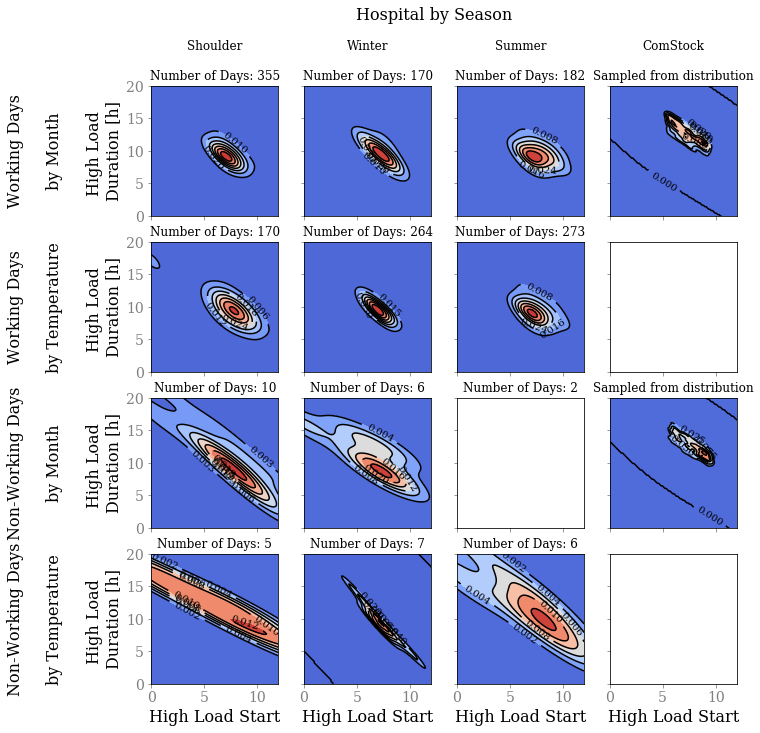

In [32]:
fig, axs = plt.subplots(4, col_n, sharex=True, sharey=True, figsize=(col_n*2.5+0.5, 11))

## Plot AMI data
# Working day
data_WD = data[data['holiday']==False]
for col_i, season in enumerate(data['season_temp'].unique()):
    for row_i, criterion in enumerate(['season_time', 'season_temp']):
        data_plot = data_WD[data_WD[criterion] == season]
        numberOfDays = data_plot.shape[0]
        try:
            f_raw_WD = regress_dist(data_plot, positions, xx)
            cfset = axs[row_i, col_i].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
            cset = axs[row_i, col_i].contour(xx, yy, f_raw_WD, colors='k')
            axs[row_i, col_i].clabel(cset, inline=1, fontsize=10)
            if row_i == 0:
                axs[row_i, col_i].set_title(f"{season}\n\nNumber of Days: {numberOfDays}")
            else:
                axs[row_i, col_i].set_title(f"Number of Days: {numberOfDays}")
        except:
            if row_i == 0:
                axs[row_i, col_i].set_title(f"{season}\n\nNumber of Days: {numberOfDays}")
            else:
                axs[row_i, col_i].set_title(f"Number of Days: {numberOfDays}")            
# Non-Working day
data_NWD = data[data['holiday']]
for col_i, season in enumerate(data['season_temp'].unique()):
    for row_i, criterion in enumerate(['season_time', 'season_temp']):
        data_plot = data_NWD[data_NWD[criterion] == season]
        numberOfDays = data_plot.shape[0]
        try:
            f_raw_WD = regress_dist(data_plot, positions, xx)
            cfset = axs[row_i+2, col_i].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
            cset = axs[row_i+2, col_i].contour(xx, yy, f_raw_WD, colors='k')
            axs[row_i+2, col_i].clabel(cset, inline=1, fontsize=10)
            axs[row_i+2, col_i].set_title(f"Number of Days: {numberOfDays}")   
        except:
            axs[row_i+2, col_i].set_title(f"Number of Days: {numberOfDays}")   
            
# Plot comStock data
if CS_building:
    samples_WD_ComStock = generate_samples_ComStock(start_time_WD_CS, duration_WD_CS, building_type)
    samples_NWD_ComStock = generate_samples_ComStock(start_time_NWD_CS, duration_NWD_CS, building_type)
    # column 1 - Working day
    f_raw_WD = regress_dist(samples_WD_ComStock, positions, xx)
    cfset = axs[0, col_n-1].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
    cset = axs[0, col_n-1].contour(xx, yy, f_raw_WD, colors='k')
    axs[0, col_n-1].clabel(cset, inline=1, fontsize=10)    
    axs[0, col_n-1].set_title("ComStock\n\nSampled from distribution")
    
    # column 2 - Non-Working day
    f_raw_WD = regress_dist(samples_NWD_ComStock, positions, xx)
    cfset = axs[2, col_n-1].contourf(xx, yy, f_raw_WD, cmap='coolwarm')
    cset = axs[2, col_n-1].contour(xx, yy, f_raw_WD, colors='k')
    axs[2, col_n-1].clabel(cset, inline=1, fontsize=10)   
    axs[2, col_n-1].set_title("Sampled from distribution")    
    
for col_i in range(col_n):
    axs[3, col_i].set_xlabel('High Load Start')
    
axs[0, 0].set_ylabel('Working Days\n\nby Month\n\nHigh Load \nDuration [h]')
axs[1, 0].set_ylabel('Working Days\n\nby Temperature\n\nHigh Load \nDuration [h]')
axs[2, 0].set_ylabel('Non-Working Days\n\nby Month\n\nHigh Load \nDuration [h]')
axs[3, 0].set_ylabel('Non-Working Days\n\nby Temperature\n\nHigh Load \nDuration [h]')

fig.suptitle(f'{building_type.capitalize()} by Season', fontsize=16)

plt.savefig(f'fig/season/{building_type}.png')